In [79]:
import pandas as pd
import numpy as np 
from nrclex import NRCLex 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from wordcloud import WordCloud
from PIL import Image

import os
import sys


from Utility_Fede import aggregation_byparks, label, new_df, count_words

#https://github.com/metalcorebear/NRCLex/blob/cda50c7d7c51709acf506b815037cb376572a629/README.md

In [22]:
#read dataframe
df = pd.read_csv ('../dataframe/df_completec.csv')


### STEP 1 - vedere il sentimento in media nei parchi 


In [23]:
#Return affect dictionary : in ogni tweet le parole con il sentimento associato
df["emotions_dict"] = df["text1"].apply(lambda x: NRCLex(x).affect_dict) 
#Return affect frequencies
df["emotions_freq"] = df["text1"].apply(lambda x: NRCLex(x).affect_frequencies)
#Return highest emotions
df["emotions_top"] = df["text1"].apply(lambda x: NRCLex(x).top_emotions)

In [24]:
#Compute the sentiment in the park with aggregation_byparks
ballyhoura_df,aggr = aggregation_byparks('ballyhoura',df)
ballyhoura_df

,ballyhoura
fear,0.024
anger,0.024
trust,0.112
surprise,0.047
positive,0.275
negative,0.054
sadness,0.015
disgust,0.003
joy,0.123
anticipation,0.153


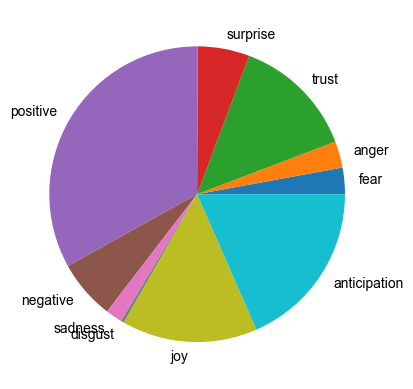

In [25]:
#create pie chart
plt.pie(aggr, labels = label) #, autopct='%.0f%%'
sns.set(rc={'figure.figsize':(20,10)})
plt.show()

Ordinare in ordine crescente per vedere qual è il sentimento piu ricorrente

In [26]:
#emotional dataframe sorted with most common words
df_em_mc = pd.DataFrame({'emotion': label, 'aggregation': aggr}).sort_values(by=['aggregation'],ascending=False)
df_em_mc.head()

,emotion,aggregation
4,positive,0.275
9,anticipation,0.153
8,joy,0.123
2,trust,0.112
5,negative,0.054


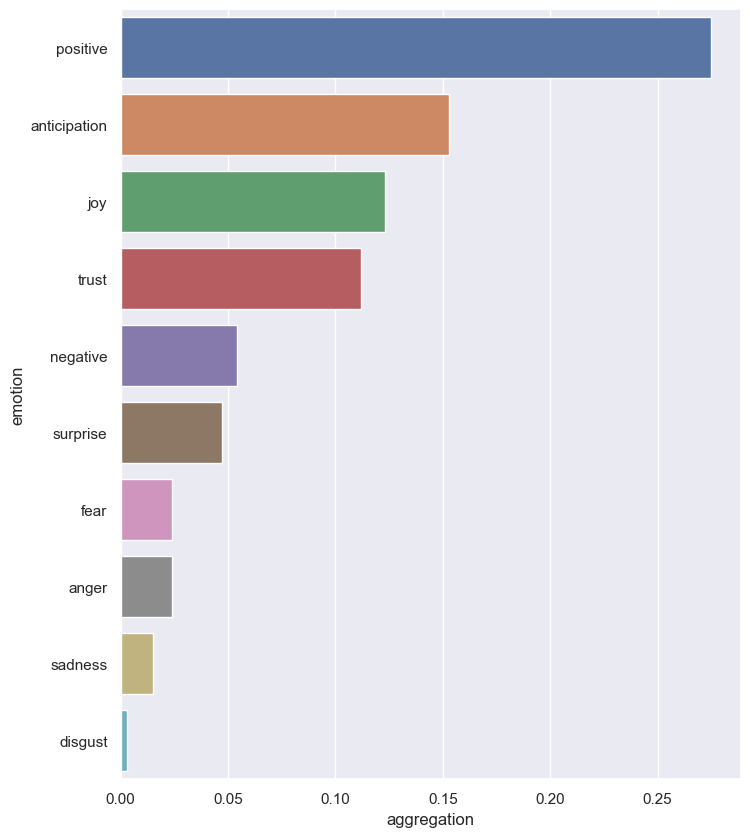

In [27]:
plt.figure(figsize=(8,10))
sns.barplot(y = 'emotion', x= 'aggregation', data = df_em_mc)
plt.show()

In [28]:
#Lo faccio per 3 parchi diversi e li confronto
ballyhoura_df,aggr = aggregation_byparks('ballyhoura',df)
westfields_df,aggr = aggregation_byparks('westfields',df)
shannon_df,aggr = aggregation_byparks('shannon',df)
ted_russel_df,aggr = aggregation_byparks('ted russel',df)

df_parks = pd.concat([ballyhoura_df, westfields_df, shannon_df, ted_russel_df], axis=1)
df_parks


,ballyhoura,westfields,shannon,ted russel
fear,0.024,0.034,0.035,0.055
anger,0.024,0.015,0.025,0.017
trust,0.112,0.080,0.128,0.162
surprise,0.047,0.019,0.046,0.019
positive,0.275,0.190,0.219,0.258
negative,0.054,0.028,0.063,0.043
sadness,0.015,0.015,0.028,0.051
disgust,0.003,0.003,0.012,0.017
joy,0.123,0.049,0.085,0.091
anticipation,0.153,0.061,0.124,0.085


Text(0, 0.5, 'Frequencies')

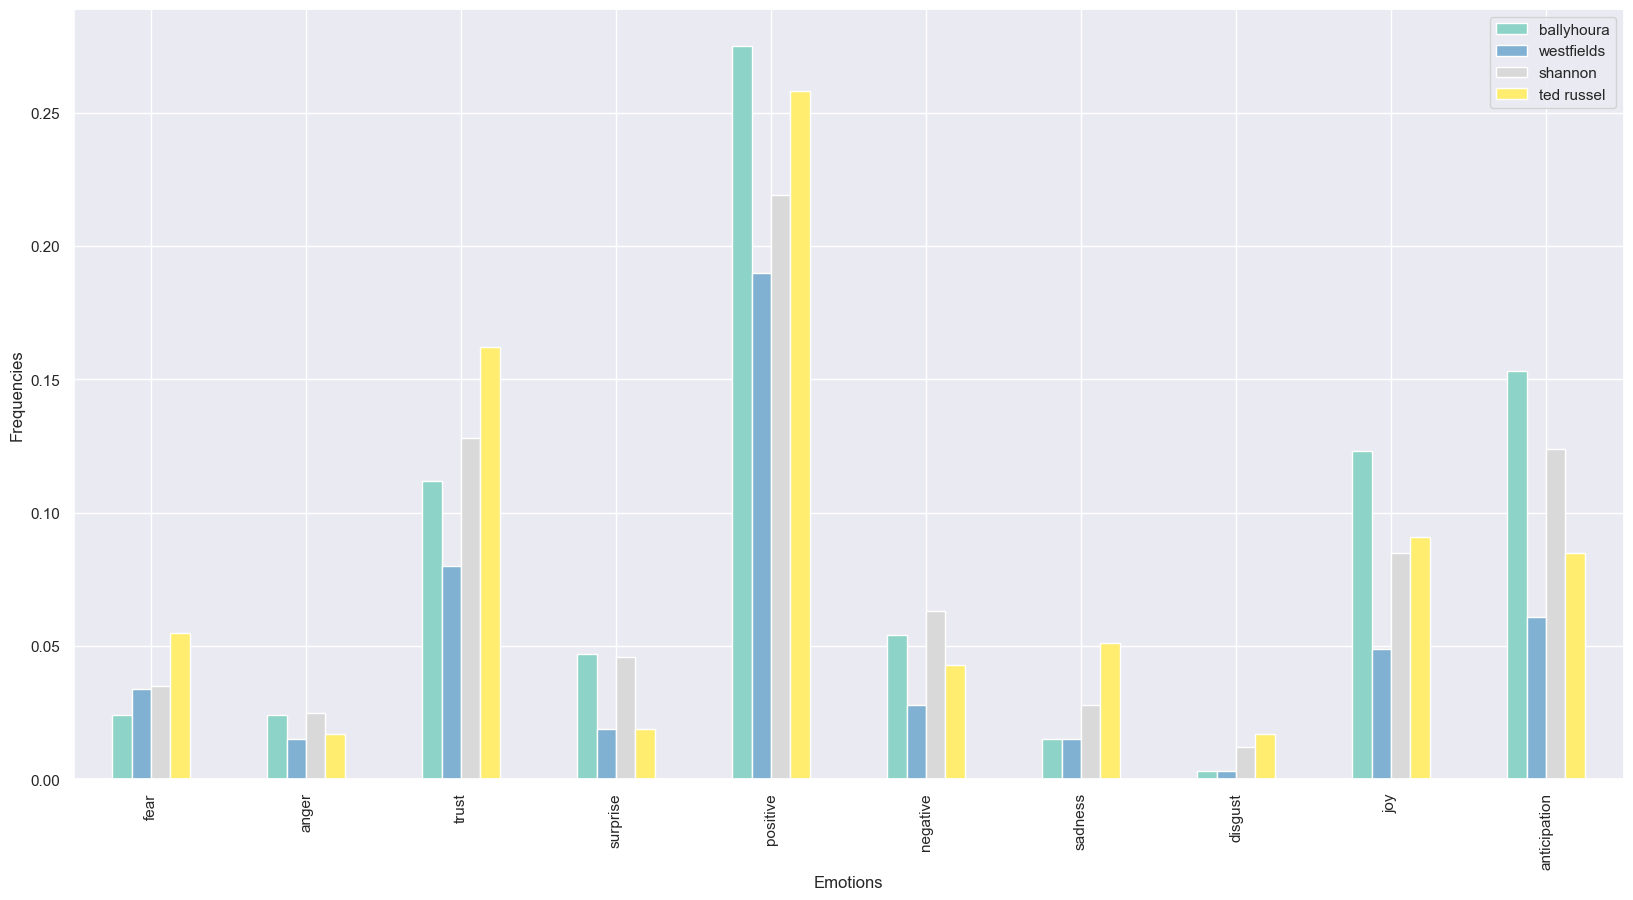

In [29]:
cmap = cm.get_cmap('Set3') # Colour map (there are many others)

df_parks.plot.bar(cmap = cmap)

plt.xlabel("Emotions")
plt.ylabel("Frequencies")

### La domanda adesso è: quali parole danno questo sentiment positivo? E quante volte compaiono?

In [30]:
df_counter = pd.read_csv('../dataframe/df_counter.csv').drop(['Unnamed: 0'], axis =1)
df_counter.columns = ['words', 'count']
df_counter

,words,count
0,adare,568
1,farm,40
2,support,303
3,limerickgoingforgold,13
4,gold,50
...,...,...
20130,uncut,1
20131,runmotivation,1
20132,parkun,1
20133,fitspo,1


Quali di queste parole si trovano nel vocabolario?

In [31]:
#join together all the tweet in the column 'text1'
long_tweet = ",".join(df["text1"])
text = NRCLex(long_tweet)
word_dict = text.affect_dict #è un dizionario
sentiment_key = list(word_dict.keys())

In [32]:
df2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in word_dict.items()]))
df2 = df2.fillna(0)
df2.head(10)

,farm,gold,team,ready,clean,base,time,creep,vote,leave,...,mite,irate,assure,brazen,respite,oversight,accountability,justice,yearning,rout
0,anticipation,positive,trust,anticipation,joy,trust,anticipation,negative,anger,negative,...,disgust,anger,trust,anger,joy,negative,positive,positive,anticipation,negative
1,0,0,0,0,positive,0,0,0,anticipation,sadness,...,negative,negative,0,negative,positive,0,trust,trust,joy,0
2,0,0,0,0,trust,0,0,0,joy,surprise,...,0,0,0,0,trust,0,0,0,negative,0
3,0,0,0,0,0,0,0,0,negative,0,...,0,0,0,0,0,0,0,0,positive,0
4,0,0,0,0,0,0,0,0,positive,0,...,0,0,0,0,0,0,0,0,trust,0
5,0,0,0,0,0,0,0,0,sadness,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,surprise,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,trust,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df3 = pd.DataFrame()
for i in label: new_df(i,df2,df3)
df3

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
farm,0,0,0,0,0,0,0,0,0,1
gold,0,0,0,0,1,0,0,0,0,0
team,0,0,1,0,0,0,0,0,0,0
ready,0,0,0,0,0,0,0,0,0,1
clean,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
oversight,0,0,0,0,0,1,0,0,0,0
accountability,0,0,1,0,1,0,0,0,0,0
justice,0,0,1,0,1,0,0,0,0,0
yearning,0,0,1,0,1,1,0,0,1,1


Creo una lista che contiene le liste delle emozioni

In [34]:
sentiment_list = []
for i in df3: sentiment_list.append(df3.loc[df3[i]!=0][i].reset_index()['index'].tolist())

In [35]:
fear_list = sentiment_list[0]
anger_list = sentiment_list[1]
trust_list = sentiment_list[2]
surprise_list = sentiment_list[3]
positive_list = sentiment_list[4]
negative_list = sentiment_list[5]
sadness_list = sentiment_list[6]
disgust_list = sentiment_list[7]
joy_list = sentiment_list[8]
anticipation_list = sentiment_list[9]


A questo punto ho df_counter = conteggio di tutte le parole e la lista dei sentimenti (pos, anticipation, ecc). Trasformo questa in un dataframe es df_pos (per positive list). 
In questo nuovo df devo aggiungere una nuova colonna chemi conteggia le parole. Tale conteggio è df_counter.
Infine ordino in ordine discendente. 

In [36]:
df_fear = count_words(fear_list,df_counter)
df_fear

,words,count
387,lose,943
280,delay,243
2833,fire,185
10724,cutting,176
1122,watch,174
...,...,...
11953,tragedy,1
12386,mortality,1
12388,captor,1
12473,hysterical,1


In [37]:
df_pos = count_words(positive_list,df_counter)
df_pos

,words,count
5202,entertainment,1061
1482,store,853
274,good,844
59,beautiful,743
1236,tree,501
...,...,...
14452,elegant,1
5327,renaissance,1
5221,flying,1
14646,aspiration,1


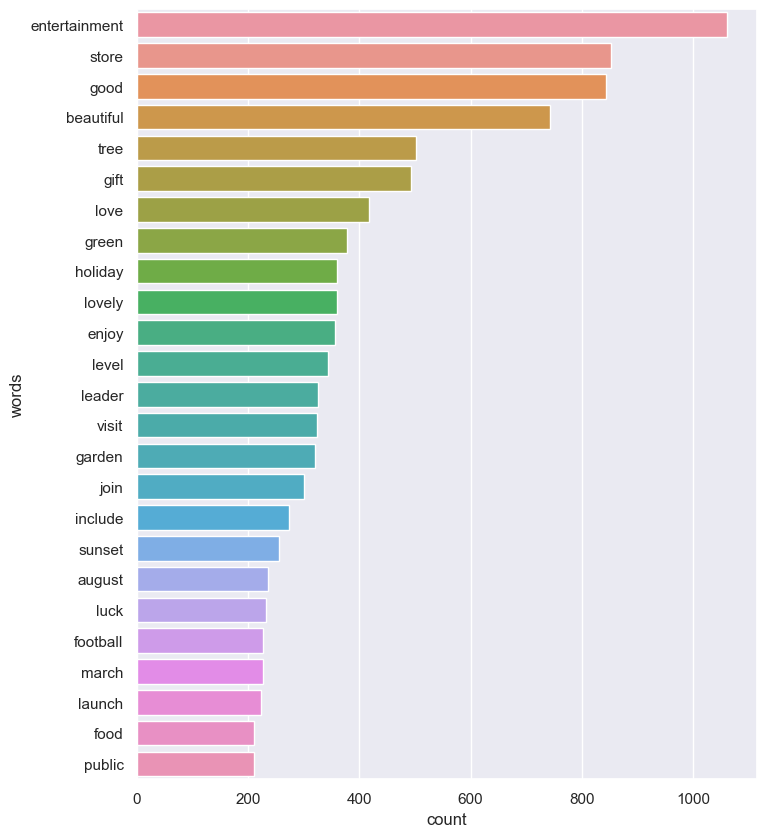

In [38]:
plt.figure(figsize=(8,10))
sns.barplot(y= 'words', x = 'count', data = df_pos[0:25]) #stampo le prime 25 parole che mi danno sentiment positive
plt.show()

## STEP 3: creare una nuvola in cui stampiamo le parole che compaiono di più in tutti i sentimenti

Parole positive

In [43]:
# Convert the word & count columns to a dict
word_pos = dict(zip(df_pos['words'].tolist(), df_pos['count'].tolist()))


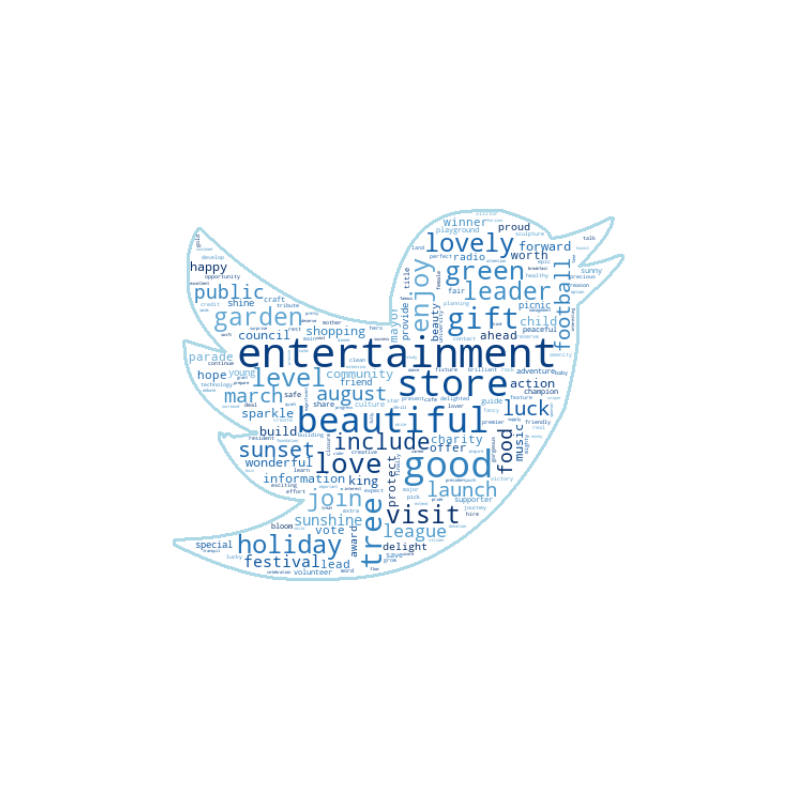

In [83]:

# open the twitter image and use np.array to transform the file to an array
mask = np.array(Image.open("C:\\Users\\micci\\Documents\\twitter.png"))

# import the desired colormap from matplotlib
cmap = mpl.cm.Blues(np.linspace(0,1,20)) 
# the darker part of the matrix is selected for readability
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 


#create and generate our wordcloud object
wordcloud = WordCloud(background_color = 'white',
                      contour_color = 'lightblue',
                      mask = mask, 
                      colormap = cmap,
                      contour_width = 2).generate_from_frequencies(word_pos)


#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()